# In this notebook, we assemble Figure 5 transcription factor gene expression boxplot for the TwinC paper. 

In [3]:
import os
import mne
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from pyjaspar import jaspardb
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from scipy.stats import mannwhitneyu
from pyjaspar import jaspardb

In [4]:
jdb_obj = jaspardb(release='JASPAR2024')


SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 20

plt.rcParams['axes.facecolor']='white'
plt.rc('font', size=SMALL_SIZE)          
plt.rc('axes', titlesize=SMALL_SIZE)    
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

hlv_gene_exp = pd.read_csv("../../data/RNA_seq_HeartLeftVentricle/gene_tpm_2017-06-05_v8_heart_left_ventricle.gct", sep="\t")

map_dict = {'SUH':'RBPJ', 'ERR3':'ESRRG', 'ZBT18':'ZBTB18', 
 'SOX10':'DOM', 'RORG':'RORC', 'STA5A':'STAT5A', 
 'RHOX11':'RHO', 'PRGR':'PGR', 'ZBT7A':'ZBTB7A', 'TYY1':'YY1', 
 'GCR':'NR3C1', 'DUX':'DUX4',  'TBXT':'T', 'NFAC1':'NFATC1', 
 'HIC1.MOUSE':'HIC1', 'FOXJ3.MOUSE':'FOXJ3'}

motifs = pd.read_csv("../../results/tf_analysis/attr_motifs.tsv", sep="\t")

motifs_list = motifs["motif ID"].to_list()
motifs_type = motifs["Transcription Factors"].to_list()

enriched_exps = dict()
other_exps = dict()
found = False
for motif, tp in zip(motifs_list, motifs_type):
    motif = motif.upper()
    if 'ZN' in motif and 'ZNF' not in motif:
        motif = motif.replace("ZN", "ZNF")
    if "::" in motif:
        motif1, motif2 = motif.split("::")
    elif "+" in motif:
        motif1, motif2 = motif.split("+")
    elif "-" in motif and motif not in ['NKX2-3', 'NKX2-4', 'NKX2-8']:
        motif1, motif2 = motif.split("-")
    elif motif in ['RHOX11']:
        motif1 = None
        motif2 = None
    else: 
        motif1 = motif
        motif2 = None

    if motif1 is not None:
        val1 = hlv_gene_exp[hlv_gene_exp["Description"] == motif1]
        if len(val1) > 0:
            val1 = val1.iloc[0].to_list()
            if tp == "enriched":
                if motif1 not in other_exps.keys() and motif1 not in enriched_exps.keys():
                    enriched_exps[motif1] = np.quantile(np.array(val1[3:], dtype=float), 0.5)
            else:
                if motif1 not in other_exps.keys() and motif1 not in enriched_exps.keys():
                    other_exps[motif1] = np.quantile(np.array(val1[3:], dtype=float), 0.5)
        else:
            val1 = hlv_gene_exp[hlv_gene_exp["Description"] == map_dict[motif1]]
            if len(val1) > 0:
                val1 = val1.iloc[0].to_list()
                if tp == "enriched":
                    if motif1 not in other_exps.keys() and motif1 not in enriched_exps.keys():
                        enriched_exps[motif1] = np.quantile(np.array(val1[3:], dtype=float), 0.5)
                else:
                    if motif1 not in other_exps.keys() and motif1 not in enriched_exps.keys():
                        other_exps[motif1] = np.quantile(np.array(val1[3:], dtype=float), 0.5)
            else:
                print(f"Didn't find {motif1}")

        

    if motif2 is not None:
        val1 = hlv_gene_exp[hlv_gene_exp["Description"] == motif2]
        if len(val1) > 0:
            val1 = val1.iloc[0].to_list()
            if tp == "enriched":
                if motif2 not in other_exps.keys() and motif2 not in enriched_exps.keys():
                    enriched_exps[motif2] = np.quantile(np.array(val1[3:], dtype=float), 0.5)
            else:
                if motif2 not in other_exps.keys() and motif2 not in enriched_exps.keys():
                    other_exps[motif2] = np.quantile(np.array(val1[3:], dtype=float), 0.5)
        else:
            val1 = hlv_gene_exp[hlv_gene_exp["Description"] == map_dict[motif2]]
            if len(val1) > 0:
                val1 = val1.iloc[0].to_list()
                if tp == "enriched":
                    if motif2 not in other_exps.keys() and motif2 not in enriched_exps.keys():
                        enriched_exps[motif2] = np.quantile(np.array(val1[3:], dtype=float), 0.5)
                else:
                    if motif2 not in other_exps.keys() and motif2 not in enriched_exps.keys():
                        other_exps[motif2] = np.quantile(np.array(val1[3:], dtype=float), 0.5)
            else:
                print(f"Didn't find {motif2}")


depleted_tfs = dict()
for i in range(15):
    this_other_tfs = np.load(f"../../results/tf_analysis/joint_negative_tfs_hg38_auroc_{i}.npz", allow_pickle=True)
    this_other_tfs = this_other_tfs['motif_auroc'][()]
    depleted_tfs = {**depleted_tfs, **this_other_tfs}

for ii in depleted_tfs.keys():
        if 'MA' in ii:
            motif = jdb_obj.fetch_motif_by_id(ii).name.upper()
        else:
            motif = ii.split("-")[2].upper()
        if 'ZN' in motif and 'ZNF' not in motif:
            motif = motif.replace("ZN", "ZNF")
        if "::" in motif:
            motif1, motif2 = motif.split("::")
        elif "+" in motif:
            motif1, motif2 = motif.split("+")
        elif "-" in motif and motif in ['EWSR1-FLI1']:
            motif1, motif2 = motif.split("-")
        else: 
            motif1 = motif
            motif2 = None

        if motif1 is not None:
            val1 = hlv_gene_exp[hlv_gene_exp["Description"] == motif1]
            if len(val1) > 0:
                val1 = val1.iloc[0].to_list()
                if motif1 not in other_exps.keys()  and motif1 not in enriched_exps.keys():
                    other_exps[motif1] = np.quantile(np.array(val1[3:], dtype=float), 0.5)
            else:
                val1 = hlv_gene_exp[hlv_gene_exp["Description"] == map_dict[motif1]]
                if len(val1) > 0:
                    val1 = val1.iloc[0].to_list()
                    if motif1 not in other_exps.keys() and motif1 not in enriched_exps.keys():
                        other_exps[motif1] = np.quantile(np.array(val1[3:], dtype=float), 0.5)
                else:
                    print(f"Didn't find {motif1}")

        

        if motif2 is not None:
            val1 = hlv_gene_exp[hlv_gene_exp["Description"] == motif2]
            if len(val1) > 0:
                val1 = val1.iloc[0].to_list()
                if motif2 not in other_exps.keys() and motif2 not in enriched_exps.keys():
                    other_exps[motif2] = np.quantile(np.array(val1[3:], dtype=float), 0.5)
            else:
                val1 = hlv_gene_exp[hlv_gene_exp["Description"] == map_dict[motif2]]
                if len(val1) > 0:
                    val1 = val1.iloc[0].to_list()
                    if motif2 not in other_exps.keys() and motif2 not in enriched_exps.keys():
                        other_exps[motif2] = np.quantile(np.array(val1[3:], dtype=float), 0.5)
                else:
                    print(f"Didn't find {motif2}")


enriched = list(enriched_exps.values())
other = list(other_exps.values())

print(f"enriched: {np.mean(enriched)}, {len(enriched)}")
print(f"other: {np.mean(other)}, {len(other)}")

common_set_attr = []
for i in enriched_exps.keys():
    common_set_attr.append([i, "Enriched", enriched_exps[i]])

for i in other_exps.keys():
    common_set_attr.append([i, "Other", other_exps[i]])

common_set_attr = pd.DataFrame(common_set_attr)
common_set_attr.columns = ["TF Name", "Transcription Factors", "HLV Gene Expression (TPM)"]

Didn't find SOX10
Didn't find SOX10
enriched: 7.870034513274336, 113
other: 5.884558165548098, 447


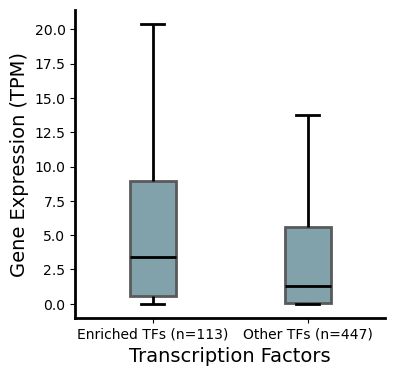

mwu p-value: 0.00012304905838405981
mwu AUROC: 0.6113915780721031
7.870034513274336
5.884558165548098


In [5]:
# Define HSL values
hue = 193
saturation = 32
lightness = 70

hue /= 360
saturation /= 100
lightness /= 100

# Convert HSL to RGB
rgb_color = hsv_to_rgb((hue, saturation, lightness))

figure, axis = plt.subplots(1, 1, figsize=(4, 4))

for ax in ['top','bottom','left','right']:
    axis.spines[ax].set_linewidth(2)


sns.boxplot(data=common_set_attr, 
            x="Transcription Factors", 
            y="HLV Gene Expression (TPM)", 
            color=rgb_color, 
            width=0.3, 
            linewidth=2, 
            showfliers=False,
            #boxprops=dict(color="black"),      
            whiskerprops=dict(color="black"),  
            capprops=dict(color="black"),    
            medianprops=dict(color="black"),  
            ax=axis)
axis.set_xticks([0, 1])
axis.set_xticklabels([f"Enriched TFs (n={len(enriched)})", f"Other TFs (n={len(other)})"])
axis.set_ylabel(f"Gene Expression (TPM)")
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
plt.savefig("../../figures/tf_analysis/enriched_gene_exp.pdf", transparent=True)
plt.show()


mwu = stats.mannwhitneyu(common_set_attr[common_set_attr["Transcription Factors"] == "Enriched"]["HLV Gene Expression (TPM)"], 
                         common_set_attr[common_set_attr["Transcription Factors"] == "Other"]["HLV Gene Expression (TPM)"], alternative="greater")
auc_mu = mwu[0]/(len(common_set_attr[common_set_attr["Transcription Factors"] == "Enriched"])*len(common_set_attr[common_set_attr["Transcription Factors"] == "Other"]))
print(f"mwu p-value: {mwu[1]}")
print(f"mwu AUROC: {auc_mu}")
print(np.mean(common_set_attr[common_set_attr["Transcription Factors"] == "Enriched"]["HLV Gene Expression (TPM)"]))
print(np.mean(common_set_attr[common_set_attr["Transcription Factors"] == "Other"]["HLV Gene Expression (TPM)"]))

common_set_attr.to_csv("../../results/tf_analysis/gene_exp_tf_set.tsv", sep="\t")

non_zero_set = common_set_attr[common_set_attr["HLV Gene Expression (TPM)"] > 0.0]
non_zero_set.to_csv("../../results/tf_analysis/gene_exp_tf_set_expressed.tsv", sep="\t")